# Fitting with sigma clipping all data

In [1]:
import numpy as np
from sklearn import metrics
from scipy.optimize import curve_fit
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import pandas as pd
from astropy.table import Table
import hdbscan
import seaborn as sns
from astropy.stats import sigma_clip

This table is the resulted af HYDRA catalog with some further cleaning procedures: error <= 0.2 in all bands, flat <= 2.0 and FWHM.

In [2]:
# Read the file with pandas. 
df = pd.read_csv('../HYDRA_errorsall_flag.csv')
df.describe()

,RA,DEC,FWHM,ISOarea,KRON_RADIUS,nDet_magPStotal,PhotoFlagDet,U_PStotal,F378_PStotal,F395_PStotal,...,e_F395_PStotal,e_F410_PStotal,e_F430_PStotal,e_G_PStotal,e_F515_PStotal,e_R_PStotal,e_F660_PStotal,e_I_PStotal,e_F861_PStotal,e_Z_PStotal
count,1.205460e+06,1.205460e+06,1.205460e+06,1.205460e+06,1.205460e+06,1205460.0,1.205460e+06,1.205460e+06,1.205460e+06,1.205460e+06,...,1.205460e+06,1.205460e+06,1.205460e+06,1.205460e+06,1.205460e+06,1.205460e+06,1.205460e+06,1.205460e+06,1.205460e+06,1.205460e+06
mean,1.574737e+02,-3.765095e+01,2.655782e+00,1.611921e+02,3.325735e+00,12.0,9.327808e-01,1.892343e+01,1.859227e+01,1.837976e+01,...,7.652235e-02,4.625796e-02,4.053473e-02,1.216494e-02,2.207754e-02,7.812072e-03,8.911540e-03,7.858082e-03,1.467912e-02,1.144869e-02
std,4.264869e+00,6.898290e+00,1.583726e+00,1.802867e+02,4.337330e-01,0.0,1.248708e+00,1.324776e+00,1.342452e+00,1.320954e+00,...,5.327117e-02,3.328123e-02,2.943722e-02,8.496807e-03,1.572316e-02,5.654017e-03,6.635798e-03,6.467499e-03,1.364234e-02,1.128786e-02
min,1.491450e+02,-4.799530e+01,0.000000e+00,7.000000e+00,0.000000e+00,12.0,0.000000e+00,1.283958e+01,1.285368e+01,1.237648e+01,...,2.506195e-03,1.981964e-03,1.869866e-03,1.074187e-03,1.679026e-03,1.000208e-03,1.000826e-03,1.000018e-03,1.223275e-03,1.000296e-03
25%,1.539022e+02,-4.365487e+01,2.092894e+00,5.700000e+01,3.044066e+00,12.0,0.000000e+00,1.809732e+01,1.775867e+01,1.756027e+01,...,3.022425e-02,1.911988e-02,1.695685e-02,5.693870e-03,1.009724e-02,3.719078e-03,4.195991e-03,3.418474e-03,5.777553e-03,4.200817e-03
50%,1.572985e+02,-3.839767e+01,2.351267e+00,9.700000e+01,3.331367e+00,12.0,0.000000e+00,1.917690e+01,1.885001e+01,1.865103e+01,...,6.433132e-02,3.838262e-02,3.352070e-02,1.021093e-02,1.844274e-02,6.402037e-03,7.228042e-03,6.079868e-03,1.068643e-02,8.046544e-03
75%,1.611113e+02,-3.235687e+01,2.858987e+00,1.950000e+02,3.583774e+00,12.0,2.000000e+00,1.994672e+01,1.963084e+01,1.941542e+01,...,1.164203e-01,6.672487e-02,5.760569e-02,1.655137e-02,3.008631e-02,1.037017e-02,1.175074e-02,1.027535e-02,1.891833e-02,1.475090e-02
max,1.659072e+02,-2.316671e+01,6.665548e+02,3.222300e+04,1.368570e+01,12.0,2.300000e+01,2.211142e+01,2.149449e+01,2.094952e+01,...,1.999998e-01,1.999961e-01,1.999177e-01,1.853062e-01,1.983804e-01,1.343458e-01,1.900271e-01,1.971328e-01,1.996143e-01,1.996316e-01


In [3]:
# define the true objective function
def objective(x, a, b):
    return a * x + b

# definition for the colors
def colour(table, f1, f2, f3, f4):
    xcolour = table[f1] - table[f2]
    ycolour = table[f3] - table[f4]
    return xcolour, ycolour

In [4]:
cx, cy = colour(df, "R_PStotal", "I_PStotal", "R_PStotal", "F660_PStotal")
# curve_fit
popt, _ = curve_fit(objective, cx, cy)
# summarize the parameter values
a, b = popt
print('y = %.5f * x + %.5f' % (a, b))

y = 0.42917 * x + -0.04333


$\textbf{Using astropy to do the fit line}$

In [5]:
from astropy.modeling import models, fitting

# initialize a linear fitter
fit = fitting.LinearLSQFitter()

# initialize a linear model
line_init = models.Linear1D()

# fit the data with the fitter
fitted_line = fit(line_init, cx, cy)
fitted_line

<Linear1D(slope=0.42916976, intercept=-0.04333331)>

In [6]:
# initialize the outlier removal fitter
or_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip, niter=4, sigma=4.0)


# fit the data with the fitter
fitted_line_, mask = or_fit(line_init, cx, cy)
filtered_data = np.ma.masked_array(cy, mask=mask)

In [7]:
# Create DataFrame with the new colums
colum1 = pd.DataFrame(cx, columns=['r - i'])
colum2 = pd.DataFrame(cy, columns=['r - Halpha'])
data = pd.concat([df["RA"], df["DEC"], df["FWHM"], df["R_PStotal"], colum1, colum2],axis=1)
data

,RA,DEC,FWHM,R_PStotal,r - i,r - Halpha
0,157.772094,-35.345371,2.728279,16.950388,0.278313,0.080336
1,158.199458,-35.345011,3.056910,16.843538,0.110605,0.010526
2,157.713716,-35.343128,2.664692,16.413769,0.212307,0.104124
3,157.599171,-35.341404,2.797201,18.900162,0.157462,0.011538
4,157.897492,-35.342729,2.615573,18.283350,0.162767,0.008461
...,...,...,...,...,...,...
1205455,164.154744,-46.645922,1.966281,18.231850,0.231547,0.062120
1205456,164.450737,-46.609075,2.143947,17.751013,0.197901,0.008356
1205457,164.360556,-46.697710,2.121539,16.843742,0.304821,0.078594
1205458,164.590195,-46.575241,2.197179,15.982592,0.204251,0.037917


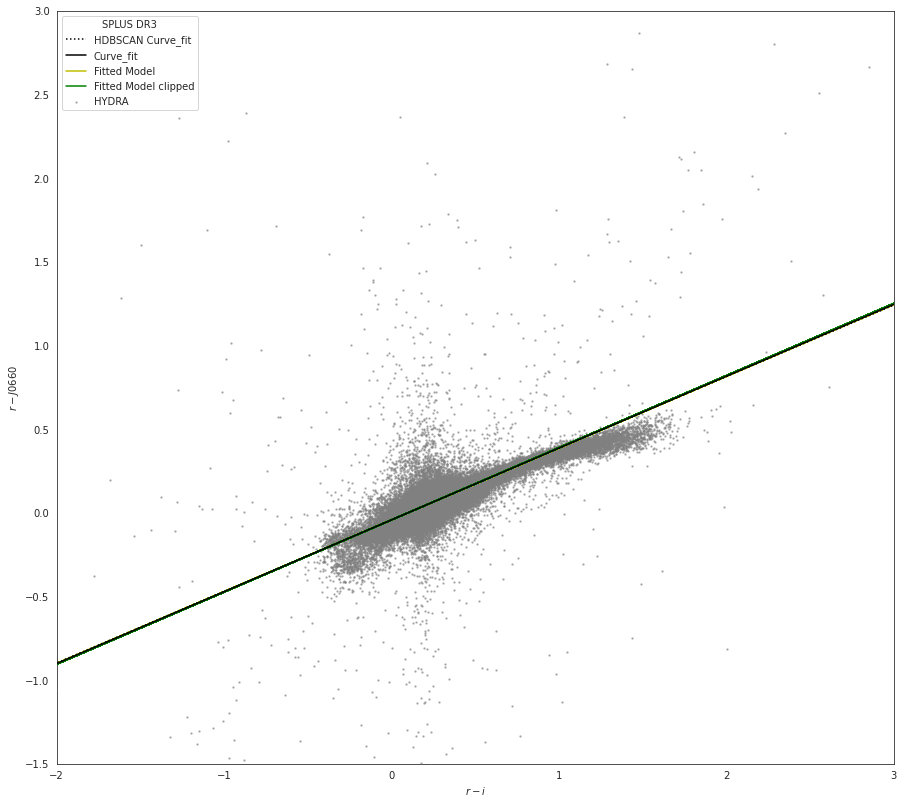

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

color_palette = sns.color_palette('Paired', 12)
with sns.axes_style('white'):
    fig, ax1 = plt.subplots(figsize=(15, 15))

    fit_line = np.linspace(-3.0, 3.0)
    scatter = ax1.scatter(
       data['r - i'], data['r - Halpha'],
        color="gray",
       s=2, 
       cmap="seismic", alpha = 0.5, zorder=4.0, label = "HYDRA")
    ax1.set(
    xlim=[-2.0, 3.0],
    ylim=[-1.5, 3.0],
    xlabel=r"$r - i$",
    ylabel=r"$r - J0660$")

    ax1.plot(fit_line, 0.42744 * fit_line - 0.04264, ls=':', color="k", zorder = 9, label='HDBSCAN Curve_fit')
    ax1.plot(fit_line, 0.42917 * fit_line - 0.04333, color="k", zorder = 8, label='Curve_fit')
    #plt.plot(cx_0, line_orig(cx_0), 'b-', label='Simulation Model')
    plt.plot(data['r - i'], fitted_line(data['r - i']), 'y-', zorder = 6, label='Fitted Model')
    #plt.plot(data['r - i'], filtered_data, "ko", label="Fitted Data")
    plt.plot(data['r - i'], fitted_line_(data['r - i']), 'g-', zorder = 7, label='Fitted Model clipped')
    #plt.plot(data['r - i'], filtered_data, 'r+', zorder=8, label="filtered data")
    #plt.plot(cx_1, fitted_model(cx_1), 'g-',
         #label="model fitted w/ original data")
    #plt.plot(cx_1, or_fitted_model(cx_1), 'r-')#, label="model fitted w/ filtered data")
    ax1.legend(ncol=1).set_title("SPLUS DR3")
    ax1.set_aspect("equal")

# Estimating parameter for statiscals

In [9]:
from sklearn.metrics import mean_squared_error

In [10]:
cy_predic = fitted_line_(data['r - i'])
sigma_fit = mean_squared_error(cy, cy_predic, squared=False)
print("The root mean squared value of the residuals around the fit:", sigma_fit)

The root mean squared value of the residuals around the fit: 0.038885279899865004


# Selecting the alpha emitters

Appliyng the selection criteria to selecting H$\alpha$ emitters. We used the same procedure in Wevers et al. (2017). The objects with H$\alpha$ excess meet the condition:

 $(r - J0660)_{obs} - (r - J0660)_{fit} \geq C \times \sqrt{\sigma^2_s - \sigma^2_{phot}}$ 
 
where $\sigma_s$ is the root mean squared value of the residuals around
the fit and $\sigma_{phot}$ is the error on the observed $(r - J0660)$ colour

Firts see an aproximation of the  4$\sigma$ cut away from the ariginal fit.

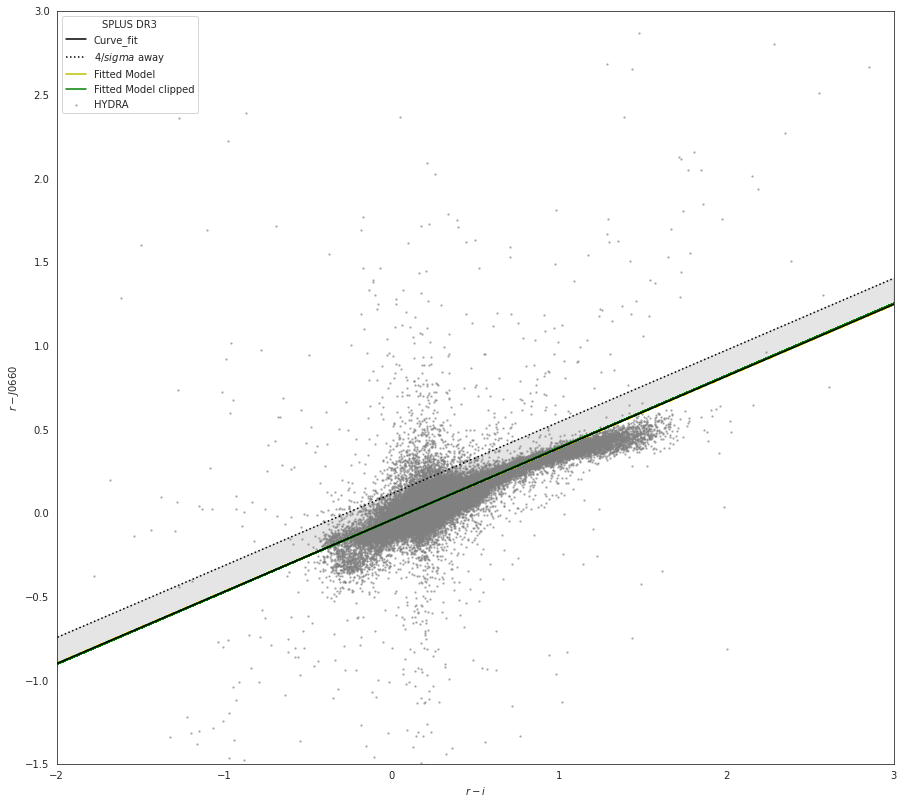

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

color_palette = sns.color_palette('Paired', 12)
with sns.axes_style('white'):
    fig, ax1 = plt.subplots(figsize=(15, 15))

    fit_line = np.linspace(-3.0, 3.0)
    scatter = ax1.scatter(
       data['r - i'], data['r - Halpha'],
       s=2, 
        color="gray",
       cmap="seismic", alpha = 0.5, zorder=4.0, label = "HYDRA")
    ax1.set(
    xlim=[-2.0, 3.0],
    ylim=[-1.5, 3.0],
    xlabel=r"$r - i$",
    ylabel=r"$r - J0660$",)
    
    #ax1.plot(fit_line, 0.42744 * fit_line - 0.04264, ls=':', color="k", zorder = 9, label='HDBSCAN Curve_fit')
    ax1.plot(fit_line, 0.42917 * fit_line - 0.04333, color="k", zorder = 8, label='Curve_fit')
    ax1.plot(fit_line, (0.42917 * fit_line - 0.04333) + 4*sigma_fit, ls=':', color="k", zorder = 8, label='4$/sigma$ away')
    plt.fill_between(fit_line, 0.42917 * fit_line - 0.04333, (0.42917 * fit_line - 0.04333) + 4*sigma_fit, color='k', alpha=0.1)
    #plt.plot(cx_0, line_orig(cx_0), 'b-', label='Simulation Model')
    plt.plot(data['r - i'], fitted_line(data['r - i']), 'y-', zorder = 6, label='Fitted Model')
    #plt.plot(data['r - i'], filtered_data, "ko", label="Fitted Data")
    plt.plot(data['r - i'], fitted_line_(data['r - i']), 'g-', zorder = 7, label='Fitted Model clipped')
    #plt.plot(data['r - i'], filtered_data, 'r+', zorder=8, label="filtered data")
    #plt.plot(cx_1, fitted_model(cx_1), 'g-',
         #label="model fitted w/ original data")
    #plt.plot(cx_1, or_fitted_model(cx_1), 'r-')#, label="model fitted w/ filtered data")
    ax1.legend(ncol=1).set_title("SPLUS DR3")
    ax1.set_aspect("equal")

In [12]:
# Errors of the colors
def errormag(table, ef1, ef2, ef3, ef4):
    excolour = np.sqrt(table[ef1]**2 + table[ef2]**2)
    eycolour = np.sqrt(table[ef3]**2 + table[ef4]**2)
    return excolour, eycolour

In [13]:
ecx, ecy = errormag(df, "e_R_PStotal", "e_I_PStotal", "e_R_PStotal", "e_F660_PStotal")
ecx

0          0.004859
1          0.004767
2          0.003710
3          0.017964
4          0.011388
             ...   
1205455    0.018533
1205456    0.013783
1205457    0.007930
1205458    0.005208
1205459    0.007061
Length: 1205460, dtype: float64

In [14]:
# Create DataFrame with the new colums with the errors on the colours
colum_ri = pd.DataFrame(ecx, columns=['e(r - i)'])
colum_rh = pd.DataFrame(ecy, columns=['e(r - Halpha)'])
data_final = pd.concat([data, colum_ri, colum_rh], axis=1)
data_final

,RA,DEC,FWHM,R_PStotal,r - i,r - Halpha,e(r - i),e(r - Halpha)
0,157.772094,-35.345371,2.728279,16.950388,0.278313,0.080336,0.004859,0.005334
1,158.199458,-35.345011,3.056910,16.843538,0.110605,0.010526,0.004767,0.005121
2,157.713716,-35.343128,2.664692,16.413769,0.212307,0.104124,0.003710,0.003995
3,157.599171,-35.341404,2.797201,18.900162,0.157462,0.011538,0.017964,0.018703
4,157.897492,-35.342729,2.615573,18.283350,0.162767,0.008461,0.011388,0.012082
...,...,...,...,...,...,...,...,...
1205455,164.154744,-46.645922,1.966281,18.231850,0.231547,0.062120,0.018533,0.019656
1205456,164.450737,-46.609075,2.143947,17.751013,0.197901,0.008356,0.013783,0.014900
1205457,164.360556,-46.697710,2.121539,16.843742,0.304821,0.078594,0.007930,0.008754
1205458,164.590195,-46.575241,2.197179,15.982592,0.204251,0.037917,0.005208,0.005712


In [15]:
# Applying the criterion 
C = 4.0 # Is the constant
crite = C * np.sqrt(sigma_fit**2 + data_final["e(r - Halpha)"]**2) + cy_predic
mask = data_final["r - Halpha"] >= crite
# Applying mask to the data
data_ha = data_final[mask]
data_ha

,RA,DEC,FWHM,R_PStotal,r - i,r - Halpha,e(r - i),e(r - Halpha)
17,158.783771,-35.339753,2.729003,16.181640,0.572233,0.448761,0.003004,0.003228
1559,157.962724,-35.027029,2.179216,18.684608,-0.006028,0.137182,0.016179,0.015085
3244,157.740394,-34.707916,4.278837,17.480165,0.208997,0.564577,0.006703,0.006266
4190,157.555714,-34.517387,11.850037,19.852774,0.099963,0.468077,0.038899,0.032124
5283,157.581291,-34.405090,44.636420,17.209835,0.333145,0.293148,0.005529,0.005772
...,...,...,...,...,...,...,...,...
1204010,165.313178,-46.568112,10.186813,19.527676,2.388526,1.503363,0.033395,0.035187
1204048,164.914981,-46.571583,1.817173,18.414335,0.582569,0.462205,0.018865,0.019567
1204070,164.939618,-46.571328,1.943377,18.259584,0.940870,0.837932,0.015745,0.016249
1204120,163.584989,-46.577825,2.508271,17.989930,0.974360,0.946860,0.013266,0.013532


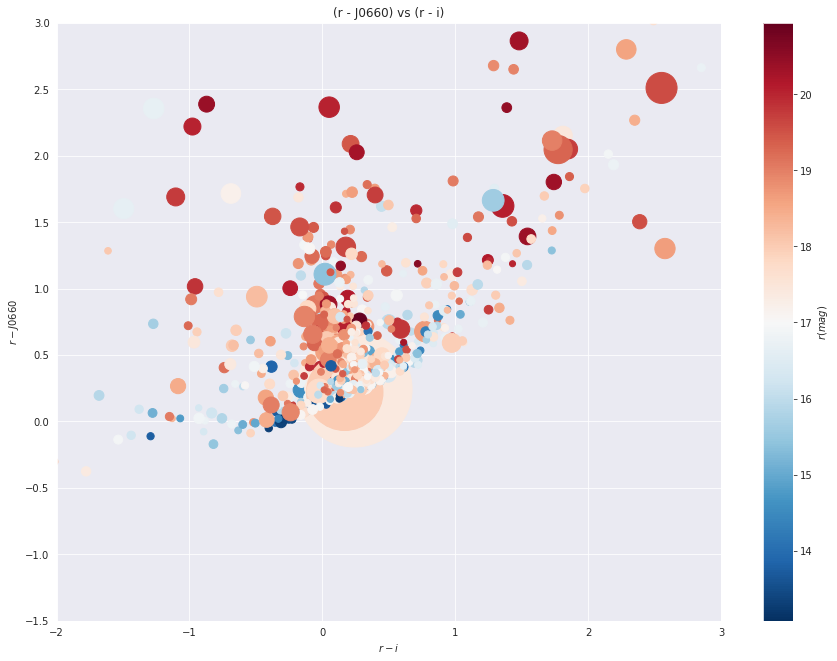

In [16]:
with sns.axes_style("darkgrid"):
    fig, ax2 = plt.subplots(figsize=(15, 11))
    scat = ax2.scatter(data_ha["r - i"], data_ha["r - Halpha"], s=20*data_ha["FWHM"], 
                             c=data_ha["R_PStotal"], cmap='RdBu_r')
    #ax2.plot(fit_line, 0.42917 * fit_line - 0.04333, color="k", ls="--")
    ax2.set(
    xlim=[-2.0, 3.0],
    ylim=[-1.5, 3.0],
    xlabel=r"$r - i$",
    ylabel=r"$r - J0660$")
    fig.colorbar(scat, ax=ax2).set_label("$r(mag)$")
    ax2.set_aspect("equal")
    ax2.set_title(r"(r - J0660) vs (r - i)")

The H$\alpha$ emitters and all data

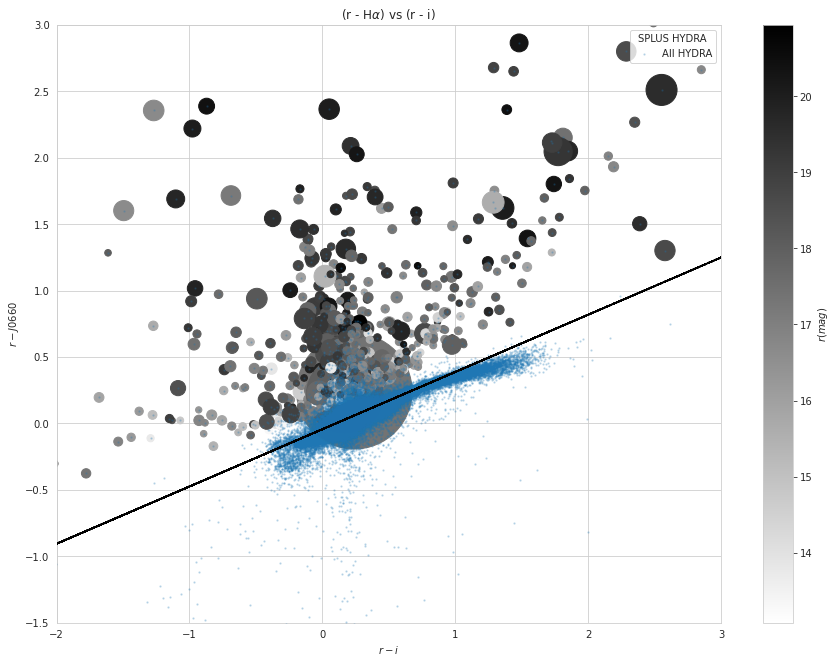

In [17]:
with sns.axes_style("whitegrid"):
    fig, ax3 = plt.subplots(figsize=(15, 11))
    scat = ax3.scatter(data_ha["r - i"], data_ha["r - Halpha"], s=20*data_ha["FWHM"], 
                             c=data_ha["R_PStotal"], cmap='gray_r')
    scatter = ax3.scatter(
       data['r - i'], data['r - Halpha'],
       s=2, 
       cmap="seismic", alpha = 0.2, zorder=4.0,
      label = "All HYDRA")
    ax3.plot(data['r - i'], fitted_line_(data['r - i']), color="k", zorder= 6., ls="--")
    ax3.set(
    xlim=[-2.0, 3.0],
    ylim=[-1.5, 3.0],
    xlabel=r"$r - i$",
    ylabel=r"$r - J0660$")
    fig.colorbar(scat, ax=ax3).set_label("$r(mag)$")
    ax3.set_aspect("equal")
    ax3.legend(ncol=2).set_title("SPLUS HYDRA")
    ax3.set_title(r"(r - H$\alpha$) vs (r - i)")

In [18]:
# Save the resultanting table
# Firts merge the orignal table with resulting one
from pathlib import Path
ROOT_PATH = Path("..")

data_orig_fin = df[mask]
data_merge = pd.merge(data_orig_fin, data_ha)

asciifile = "hydra_Halpha.ecsv" 
Table.from_pandas(data_merge).write(ROOT_PATH / asciifile, format="ascii.ecsv")